# Machine Determination of Better Representations of Multiphase Equations of State for Subsurface Flow Simulation

### *or*

# Solution of Differential Algebraic Equations with Local Constraints on the Latent Space of an Autoencoder
## Alejandro Francisco Queiruga
### Lawrence Berkeley National Lab

## Outline

1. What problems am I trying to solve?
2. Phase transition difficulties
3. Rephrase our equations
4. The classical pendulum
5. Plugging autoencoders into equations
6. Unsupervised learning for phases
7. Batch training and testing of simulations

## What kinds of problems?

<img src='slides/simple_wells.png' width=500>

Single phase Darcy's law is easy:

\begin{equation}
M \partial_t p = \nabla \cdot \frac{k}{\mu} \nabla p
\end{equation}

## What kinds of problems?

<img src='slides/complex_wells.png' width=500>



- Multicomponent mass and heat transfer
- Big ranges in our problems: depths, temperature fluxes, chemical
  compositions, percipates...



## Multiphase Transport Equations

Mass balances and energy balance:

\begin{align}
\partial_t \rho_{H_2O} & = \nabla \cdot \frac{k_1(p,T)}{\mu} \nabla p \\
\partial_t \rho_{CO_2} & = \nabla \cdot \frac{k_2(p,T)}{\mu} \nabla p \\
\partial_t \rho_{CH_4} & = \nabla \cdot \frac{k_3(p,T)}{\mu} \nabla p \\
\partial_t \sum \rho u & = \nabla \cdot q 
\end{align}

- Complicated equations and empirical fits for everything
- Mass fraction and multiple phases for each material:

\begin{equation}
\rho = X_{H_2O}\left(S_{gas} \rho_{gas} + S_{liq} \rho_{liq} + S_{ice} \rho_{ice} + S_{crit} \rho_{crit} \right)
\end{equation}

(Not shown: continuum mechanics and chemical reactions!)

## Multiphase representation is the hard part

<img src='slides/phase_beaker.png' width=500>


First steps: homogenized beaker with pure water

- Transition between phases
- Equilibria with coexisting phases
- Compositional changes

How do we represent and solve this?

## What is a phase?

![watereos](figures/phase_diagram.png)

Phase diagram of water

- Human object recognition distinguishes phases
- Sudden changes in material properties

> Phase transitions occur when the thermodynamic free energy of a system is non-analytic for some choice of thermodynamic variables (cf. phases).

https://en.wikipedia.org/wiki/Phase_transition

## Water EOS

In [3]:
from IPython.display import IFrame
IFrame('figures/water_eos.html',width=700,height=500)

Used IAPWS empirical fits to make this data set. Colored by phase, including mixtures.

## Water EOS

<img src="figures/water_eos.png" width=500>
Used IAPWS empirical fits to make this data set. Colored by phase, including mixtures.

# Curve fits are complicated (and arbitrary):

```python
def gibbs_liquid_h2o(T,p): # From IAPWS '97
    p1_star = 1.653e7
    T1_star  = 1.386e3
    n1 = [ 0.14632971213167e00, -0.84548187169114e00,
          -3.7563603672040e+00,  3.3855169168385e+00, 
          -0.95791963387872e00,  0.15772038513228e00,
          -1.6616417199501e-02,  8.1214629983568e-04, 
           2.8319080123804e-04, -6.0706301565874e-04,
          -1.8990068218419e-02, -3.2529748770505e-02, 
          -2.1841717175414e-02, -5.2838357969930e-05,
          -4.7184321073267e-04, -3.0001780793026e-04, 
           4.7661393906987e-05, -4.4141845330846e-06,
          -7.2694996297594e-16, -3.1679644845054e-05, 
          -2.8270797985312e-06, -8.5205128120103e-10,
          -2.2425281908000e-06, -6.5171222895601e-07, 
          -1.4341729937924e-13, -4.0516996860117e-07,
          -1.2734301741641e-09, -1.7424871230634e-10, 
          -6.8762131295531e-19,  1.4478307828521e-20,
           2.6335781662795e-23, -1.1947622640071e-23, 
           1.8228094581404e-24, -9.3537087292458e-26  ]
    i1 = [  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,   
            1,  2,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,    
            8,  8, 21, 23, 29, 30, 31, 32  ]
    j1 = [ -2, -1,   0,   1,   2,   3,   4,   5, -9, -7, -1,  0,  1,    
               3, -3,   0,   1,   3,  17,  -4,   0,  6, -5, -2, 10, -8,   
              -11, -6, -29, -31, -38, -39, -40, -41  ]
    p_i = p/p1_star
    t_i = T1_star/T
    return R*T*sum([ n*(7.1-p_i)**I*(t_i-1.222)**J
            for n,I,J in zip(n1,i1,j1)])
density_region1,enthalpy_region1 = density_enthalpy(gibbs_region1)
```

## How do we solve this? State Machines

Gridblocks have two unknowns `X1 X2` and an additional `phase` tag.

- Gas: $X = \{p,T\}$  
  $\rho_{gas}(p,T) = $ one fit
- Liquid: $X = \{p,T\}$  
  $\rho_{liq}(p,T) = $ another fit
- Liq-Gas: $X = \{S_{gas},T\}$  
  $\rho_{mix}(S,T) = S \rho_{gas}(p^*(T),T)+ (1-S) \rho_{liq}(p^*(T),T)$ 

<img src='slides/phase_2.png' width=500>

- Need potentially different variables for each state
- Equilibria usually use a phase saturation $S$
- Need logic to handle state of the material
- Limits discretization choice


## State machine for phase transitions:

Formulate balance equations as
\begin{equation}
R(X ; phase) = 0
\end{equation}
Solve the differentiable part:
\begin{equation}
\frac{\partial R}{\partial X}\Delta X^{k+1/2} = -R(X^k ; phase^k)
\end{equation}
and iterate on the nondifferential part:
\begin{equation}
phase^{k+1},X^{k+1} = statemachine(X^{k+1/2} ; phase^k)
\end{equation}

```C
switch phase_old:
  case gas:
    if p,T crossing boundary:
      phase_new = liquid_gas
  case liquid:
    if p,T crossing boundary:
      phase_new = liquid_gas
  case liquid_gas:
    if S_gas >= 1:
      phase_new = gas
    if S_liquid >= 1:
      phase_new = gas
```

- Lots of bug ridden coding!
- No quadratic convergence
- Easily unstable! Need a lot of hacks, like overshoots:
\begin{equation}
p_{new} = (1+10^{-6})p_{old}
\end{equation}

## It gets combinatorially more complex:

<img src='slides/phase_4.png' width=500>

- 8 states (4 phases with 4 equilibria surfaces)
- 10 possible state transitions
- Only one material!
- (There are more crystal phases we didn't consider.)

## Application: States and Primary Variables for Methane Hydrates

<img src="slides/primary_variable_table.png">

- 3 components: Water, Methane, Salt
- 4 phases: aqueous, gas, water-ice, water-methane hydrate
- 13 states spanning just the regime we care about
- Would need even more states to handle percipitation

## How do we solve this better?

Take a step back:
- Forget about phases and states.
- Material is a manifold of possible intensive properties.
- **It's just empirical data**.
- We have observations and expect to stay on these observations.
- We just need _**any**_ representation of this constraint.

## A Constrained Differential Algebraic Equation


Solve for $\rho(t), \, h(t), \, p(t),\, \text{and}\, T(t)$ satisfying:
\begin{align}
\partial_t \rho & = \nabla \cdot \mathbf{k}\nabla p + r & \quad \}\text{mass balance}\\
\partial_t (\rho h-p) & = \nabla \cdot \mathbf{k'}\nabla T + s & \quad \}\text{energy balance}\\
\end{align}
such that they lie on the material EOS,
\begin{equation}
eos(\rho,h,p,T) = 0 \quad \text{or} \quad \{\rho,h,p,T\} \in \{ eos \}
\end{equation}
We just made the problem harder.

## The Archetypical Constraint Problem: The Pendulum

Solve for $x(t),y(t)$ stationary on
\begin{equation}
L(x,y) = \frac{1}{2}m\left(\dot{x}^2 + \dot{y}^2\right) - m g y
\end{equation}
subject to
\begin{equation}
x^2 + y^2 = R^2
\end{equation}
Could do spring penalty, Lagrange multiplier, or...

The Lagrangian mechanics formulation lets us introduce a parameterization:
\begin{equation}
x = R \cos \theta, \quad y = R \sin \theta
\end{equation}
to plug into the Lagrangian:
\begin{equation}
L(\theta) = \frac{R^2}{2} \dot{\theta}^2 + g R \sin \theta
\end{equation}
The equations of motion in terms of $\theta$ are then:
\begin{equation}
\frac{\mathrm{d}}{\mathrm{d}t}\frac{\partial L}{\partial \dot{\theta}} = \frac{\partial L}{\partial \theta}
\end{equation}

## The Pendulum

The choice of $\theta$ is arbitrary. There are infinimately choices. 

Suppose we only have data: (Imagine the EOS plot I showed earlier.)

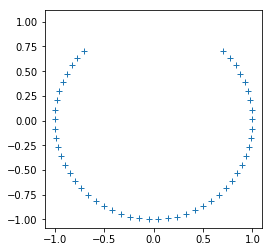

In [9]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
theta = np.linspace(-np.pi*1.25,0.25*np.pi,50, dtype=np.float32)
data = np.vstack([np.cos(theta), np.sin(theta)]).T
plt.plot(data[:,0],data[:,1],'+')
plt.axis('square');

We're looking for a mapping from the set of points onto one variable.

## Autoencoders

![autoencoder](slides/autoencoders.png)

$\theta$ is one instance of an **autoencoder**. We can look for one without the geometric intuition.

## Autoencoders
Solve the minimization problem on data set $x$ for parameters $a$
\begin{equation}
\min_a \sum_x \left( x - D(E(x;a);a) \right)^2
\end{equation}
where $q = E(x)$
with `len(q)<len(x)`.

- $q$ represents a point on the *Latent Space*
- Pick the dimension of $q$ based on prior intuition of the manifold (or tune it)
- Pendulum is a 1D manifold, so look for a 1D $q$
- It's very smooth and continuous so let's use polynomials:

\begin{equation}
\left\{\begin{array}{c} x\\y\end{array}\right\}
\rightarrow W^1 x^n \rightarrow q \rightarrow W^2 x^n \rightarrow 
\left\{\begin{array}{c} x\\y\end{array}\right\}
\end{equation}

```python
def encode(self, x, name=None):
    N_coeff = atu.Npolyexpand( self.size_x, self.Np_enc )
    We1 = self._var("enc_W", (N_coeff, self.size_q) )
    be1 = self._var("enc_b", (self.size_q,) )
    q = tf.matmul( atu.polyexpand(x, self.Np_enc), We1 ) + be1
    return tf.identity(q,name=name)
def decode(self, q, name=None):
    N_coeff = atu.Npolyexpand( self.size_q, self.Np_dec )
    We1 = self._var("dec_W", (N_coeff, self.size_x) )
    be1 = self._var("dec_b", (self.size_x,) )
    x = tf.matmul( atu.polyexpand(q, self.Np_dec), We1 ) + be1
    return tf.identity(x,name=name)
def make_goal(self, data):
    pred = self.decode(self.encode(data))
    # p = tf.reduce_sum(tf.pow( data - pred, 2) ) 
    p = tf.losses.mean_squared_error(data, pred)
    return p
```

### Caveats: Topology

- We can't encode a full circle. 
- The inner space of this arbitrary architecture is a disk.
- We would need multiple charts to span the circle (more dimensions to $q$ + chart selection), or pick an encoder that maps onto the right topology. 

![bad pendulum](figures/bad_pendulum.png)

- This is why I chopped off the top.

- Fortunately EOSes are disks so we don't need to solve this problem.


## Solving the Lagrangian: Just do it.

Treat the autoencoder the same as $x(\theta)$, plugging in 
\begin{equation}
L(x(q),v(q,\dot{q}))
\end{equation}
and build the DAE we know from physics:
\begin{equation}
\frac{\mathrm{d}}{\mathrm{d}t}\frac{\partial L}{\partial \dot{q}} = \frac{\partial L}{\partial q}
\end{equation}
where we get the velocity with the chain rule:
\begin{equation}
v = \frac{\partial x}{\partial q} \dot{q}
\end{equation}

Implement it in the TensorFlow syntax (it's a near-complete, albeit troublesome, language):
```python
def L(i_q,i_qdot):                               # Input placeholders
    x = au.decode(i_q)                           # Trained decoder
    dxdq = atu.vector_gradient(x,i_q)            # chain rule
    v = tf.einsum("ikj,ij->ik",dxdq,i_qdot)      # velocity
    L = 0.5*tf.einsum("ij,ij->i",v,v) - g*x[:,1] # action
    return x,v, tf.expand_dims(L,-1)             # return TF graphs
```

Then plug it into a Runge Kutta (trapezoidal) to solve with Newton's method:
\begin{equation}
\frac{\partial L}{\partial \dot{q}}_i - \Delta t \frac{\partial L}{\partial q}_i = \frac{\partial L}{\partial \dot{q}}_0 + \Delta t \frac{\partial L}{\partial q}_0
\end{equation}

## Solving the Lagrangian: Just do it.
Then we just build the expressions we need:
```python
o_x,o_v,Li = L(i_qi,i_vi)
dLi_dv = atu.vector_gradient(Li,i_vi)
dLi_dq = atu.vector_gradient(Li,i_qi)
```
descritize in time with a one-step implicit Runge-Kutta
```python
lhs = dLi_dv - Dt * aii * dLi_dq
rhs = dL0_dv + Dt * (1.0-aii) * dL0_dq
```
and take the tangents we need:
```python
KV = atu.vector_gradient(lhs,i_vi)
KQ = atu.vector_gradient(lhs,i_qi)
Ktot = Dt*KQ + KV
```

Then we do a Newton's method loop:
```python
# Encode an initial condition
theta_init = - 0.5*np.pi/2.0
x_init = np.array([[np.cos(theta_init),np.sin(theta_init)]])
q_0[:] = au.o_q.eval(feed_dict={au.i_x:x_init})
v_0[:] = 0.0
for it in range(1000):
    # Macro for tensorflow call
    ev = lambda x : sess.run(x,feed_dict
        ={i_qi:q_i,i_q0:q_0, i_vi:v_i, i_v0:v_0})
    rhs_0 = ev(rhs)
    # Newton's method loop
    for k in range(10):
        # Assemble
        K_k,lhs_k= ev(Ktot), ev(lhs)
        R = rhs_0 - lhs_k
        # Solve for update to qdot
        Dv = np.linalg.solve(K_k[0,:,:], R[0,:])
        v_i[:] += Dv
        # Use second-order RK formula to update q
        q_i[:] = q_0 + ev(Dt)*((1.0-aii)*v_0 + aii*v_i)
        n = np.linalg.norm(Dv)
        if n<2.0e-7: break
    v_0[:] = v_i[:]
    q_0[:] = q_i[:]
    # Saving data requires calling the decoder
    series_x.append(ev(o_x)[0,:])
    series_v.append(ev(o_v)[0,:])
```

Copy-and-paste of the implementation!

## Solutions of the Pendulum

<img src="figures/pendulum_q.png" width=800>

- We solved for $q(t)$ and $\dot{q}(t)$
- Decode $x,y$ and $v_x,v_y$ as a post-process

# Back to Multiphase EOS

Solve for $q_1(t)$ and $q_2(t)$ such that:
\begin{align}
\partial_t \rho(q_1,q_2) & = \nabla \cdot \mathbf{k} \nabla p(q_1,q_2) + r \\
\partial_t \rho h(q_1,q_2)-p & = \nabla \cdot \mathbf{k'}\nabla T(q_1,q_2) + s
\end{align}
where $\rho(q_1,q_2)$ etc. are the back of an autoencoder:
\begin{equation}
\left\{ \begin{array}{c}
T\\ p\\ \rho\\ h
\end{array}\right\} \rightarrow  E \rightarrow 
\left\{ \begin{array}{c} q_1\\q_2 \end{array} \right\}\rightarrow D \rightarrow 
\left\{ \begin{array}{c}
T\\ p\\ \rho\\ h
\end{array}\right\}
\end{equation}
Using the autoencoder to automatically remove the local constraint:
\begin{equation}
eos(D(q_1,q_2)) = 0 \, \forall \,q_1,q_2
\end{equation}

**Only training the material representation, not the balance laws.**

## Model Architectures

<img src="slides/networks.png" width=700>

## Model Architectures

<img src="slides/classifier_network.png" width=700>

Allows for unsupervised learning of phases based on what makes a good fit.

## Feature Identification

<video controls preload="auto" width="500">
<source src="slides/evo.mp4" type="video/mp4">
Your browser does not support the video tag.
</video>

## Compare to the original labels:

![watereos](figures/water_eos.png)

## Sometimes optimization fails

<img src="slides/classifier_bad.png" width=500>

Same architecture optimized with a different seed.

## $T,p,\rho,h$ are smooth in $q_1,q_2$

In [4]:
IFrame("slides/water_slgc_logp_64_qq_plots.html",1200,650)

# Methodology

![human methodology](slides/user_workflow.png)

## Methodology

1. Make a database of $T,p,\rho,h,X_1,...$  
  - Piece together empirical fits for each phase from literature
  - (*Experimental data in the future*)
1. Normalize (and $\log(p)$) the database, shuffle it  
  - $\log(p)$ distributes the low-$p$ phases evenly w.r.t. high-$p$ phases
1. Train the autoencoder
  - Don't use phase labels
  - Batch test architectures
1. Load the models and generate physics code
1. Verify and grade architectures on tests
  - Need more than autoencoder mean-squared-error
  - Differentiability and numerical stability in simulation
  - Evaluation speed (billions of times in a simulation!)
1. Pick best one to package into production code

Can be automated after step 1.

## Transformed Field Equations

<img src="slides/transformed_simulation.png" width=600>

## Solving the equations:

First, we had a constrained DAE:
\begin{align}
\frac{\mathrm{d}}{\mathrm{d}t} m(T,p,\rho,h) &= r(T,p,\rho,h)\\
eos(T,p,\rho,h) &= 0
\end{align}
with no good representation of $eos$ everywhere.

The autoencoder parameterizes the constraint :
\begin{equation}
\frac{\mathrm{d}}{\mathrm{d}t} m(D(q)) = r(D(q))
\end{equation}
Apply a Runge-Kutta to get: (BW Euler)
\begin{equation}
0 = R(q^i) = m(q^{i}) - m(q^{0}) - \Delta t \, r(q^i)
\end{equation}
**By design** $R(q)$ is smooth enough to solve with Newton's method:
\begin{equation}
\frac{\partial R}{\partial q} \Delta q^{k+1} = R(q^k)
\end{equation}
(Well, it's a hard nonlinear problem, but a smooth one!)

## Testing the Method

Three different extents:
1. Linear Equation of State  
  -  **Test!**
  - Reduces to single phase Darcy's law problem (slide 1)
  - $ p = 10^5+[-10^3, 10^3] Pa,\quad T = [ 19, 21 ] ^o C$
2. Water Liquid-Gas Regime  
  - One phase boundary  
  - $ p = [100,5\times 10^5] Pa, \quad T = [274,594] K$
3. Water Solid-Liquid-Gas-Supercritical Regimes  
  - No linear mapping to latent space  
  - Entire span
  - $ p = [6\times 10^{-6},3\times 10^8]Pa, \quad T = [150,1000] K $


## Testing the Method

Multiple test problems that move through the phase diagram:
```python
class Transition_L2G():
    t_max = 1000.0
    initial = dict(T=350,p=5.0e5)
    params =  dict(k_p=1.0e-4,k_T=1.0e4)
    @staticmethod
    def schedule(sim,t):
        sim.set_params(T_inf=350,p_inf=5.0e3)

class Cycle_sgclg():
    t_max = 5000.0
    initial = dict(T=250,p=5.0e3)
    params =  dict(k_p=1.0e-4,k_T=1.0e3)
    @staticmethod
    def schedule(sim,t):
        if t<1000.0:
            sim.set_params(T_inf=800,p_inf=5.0e4)
        elif t<2000.0:
            sim.set_params(T_inf=800,p_inf=3.0e7)
        elif t<3000.0:
            sim.set_params(T_inf=400,p_inf=3.0e7)
        elif t<4000.0:
            sim.set_params(T_inf=400,p_inf=5.0e3)
            
...
```

## Looking at single runs:

<img src="slides/okay_problem_pT.png" width=500 style="align:left"><img src="slides/okay_problem_Tprhoh.png" width=500 style="align:right">

## Looking at single runs:

<img src="slides/bad_problem_pT_follows_boundary.png" width=500>
Classifying one followed the boundary instead of crossing.

# Grading the Architectures

Analyze the training state and all of the test cases:

. | name | train_goal | succ | min_err | max_err | run_time 
---|---|---|--- |---|---|---
x | Classifying_2,4,12,24,sigmoid_0  | 3.14e-04 |  3 | 2.61e-03 | 3.90e+04 | 138.3
x | Poly_3,7                         | 5.00e-05 |  2 | 6.55e-05 | 1.45e-01 | 259.3
x | Classifying_2,6,18,36,sigmoid    | 1.39e-05 |  2 | 6.21e-10 | 1.67e-01 | 377.0
x | Deep_2,(12),3,(12,12,12)         | 2.54e-05 |  2 | 7.63e-06 | 2.09e-01 | 59.6
x | Deep_1,(12),1,(12,12,12)         | 2.92e-05 |  2 | 1.67e-08 | 3.38e+04 | 54.7
x | Classifying_2,1,12,24,sigmoid    | 8.82e-05 |  3 | 1.05e-05 | 4.05e+04 | 36.9
x | Classifying_2,4,12,24,sigmoid    | -1.00e+00 |  2 | 1.22e-09 | 1.51e-01 |  158.3
x | Classifying_2,5,12,24,sigmoid    | 1.37e-05 |  3 | 2.44e-05 | 4.03e+04 | 227.5
x | Classifying_2,3,12,24,sigmoid    | 1.75e-05 |  2 | 9.05e-06 | 1.26e-01 | 88.4
x | Deep_1,(),1,(12,12,12)           | 7.31e-02 |  2 | 4.27e-06 | 4.08e+03 | 71.9
x | Poly_2,7                         | 1.12e-04 |  3 | 8.47e-09 | 4.03e+04 | 253.6
x | Classifying_2,6,12,24,sigmoid    | 6.16e-05 |  2 | 4.56e-03 | 4.05e+04 | 314.2
x | Classifying_2,6,24,48,sigmoid    | 2.83e-06 |  2 | 6.34e-10 | 1.70e-01 | 368.4

Only passes my tests on the linear EOS:

. | name | train_goal | succ | min_err | max_err | run_time |
 ---|---|---|--- |---|---|---
o | Poly_1,1                         | 3.53e-06 |  1 | 2.54e-12 | 2.14e-06 | 0.5

Still debugging...

## Things I'm trying: Better Training

- Add the contractive autoencoder penalty:
\begin{equation}
L(x) = \|x-D(E(x))\|^2_2 + \lambda\|E(x)\|_ F^2
\end{equation}
Makes distribution of $q$ more uniform.
- Try adding biases to the initial conditions for the latent space using intuition:
    1. fully random
    2. bias T,p: $q_1 \approx p, q_2 \approx T$
    3. bias $\rho$, h $q_1 \approx \rho, q_2 \approx h$

## Things I'm trying: Mixing in Linear Regression:

The back of this needs to be accurate regression. Get $(X^T X)^{-1}X^T R$ by:
\begin{align}
 \mathbf{G}\left(X_{train}\right) &= \sum_{x\in X_{train}}\frac{\partial L}{\partial W^{dec}} \\
\mathbf{H}\left(X_{train}\right) &= \sum_{x\in X_{train}}\frac{\partial^2 L}{\partial (W^{dec})^2}
\end{align}
and then solving:
\begin{equation}
[\mathbf{H}] \Delta W^{dec} = -\{\mathbf{G}\}
\end{equation}
Hypothesis: Use SGD on the whole network to learn the latent space, then do the linear regression step to get the last layer's weights "perfect."

But there seems to be a bug. I put this step into a callback at triggers every few epochs, gives a $10^-5$ loss, but then it diverges when it goes back to SGD.


## Engineering Challenges

- Putting `session.run` inside of an inner loop is very expensive
- Computing graphs for Hessians for linear regression takes minutes
- MonitoredTrainingSession checkpoints and Summary logs for tensorboard takes 100MB-1GB+ per architecture! They only have a few hundred parameters!
- Getting the slopes right is very important for solving the physics.  
  Try putting gradients in the loss? $\|\partial p / \partial T - \partial p / \partial T\|$
- I'm experimenting with Julia and Flux.jl

## Conclusions

- Deep learning to replace and improve hand-baked equations and algorithms
- Can do unsupervised phase classification
- **Only training the material representation, not the balance laws**
- Extend to more complicated materials
- Put into a flow simulation
- Close loop on testing with reinforcement learning
- Add in L1 regularization

**Goal:** Automate integration of data analysis into writing the simulation

## Future Work

This is a proof of concept. The motivation is encoding more complicated states and solve intractable physics on those latent spaces:

Fracture simulations with strain \& fracture energies, etc.
<img src="slides/fracture_pic.png" width=700>

Can we find a Lagrangian stationary path in the compressed space?

https://github.com/afqueiruga/FractureDB

# Thank you

# Outro

Where do we go from here with machine learning?

Models are snippets of computer programs.

<img src="slides/handoff.png" width=600>

**Which parts of your program can you get the computer to write?**